# import package

In [ ]:
#import package

import glob

import os.path as osp

import random

import numpy as np

import json

from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

#파이토치 버전
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  1.13.0+cu116
Torchvision Version:  0.14.0+cu116


In [ ]:
#난수 시드 설정
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# 이미지 전처리

In [ ]:
#입력 이미지의 전처리 클래스
#훈련시와 추론시 처리가 다르다

class ImageTransform():
    
    """
    이미지 전처리 클래스, 훈련시, 검증시의 동작이 다르다.
    이미지 크기를 리사이즈하고, 색상을 표준화

    훈련시에는 RandomResizedCrop과 RandomHorizontalFlip으로 데이터 확장

    Attributes
    ---------------
    resize: int
        리사이즈 대상 이미지의 크기

    mean: (R,G,B)
        각 색상 채널의 평균값
    
    std : (R,G,B)
        각 색상 채널의 표준편차
    """

    def __init__(self, resize, mean, std):
        
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize,scale = (0.5,1.0) #데이터 확장
                ),
                transforms.RandomHorizontalFlip(), #데이터 확장
                transforms.ToTensor(), #텐서 변환
                transforms.Normalize(mean,std) #표준화
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize), #리사이즈
                transforms.CenterCrop(resize), #이미지 중앙을 resize*resize로 자르기
                transforms.ToTensor(), #텐서로 변환
                transforms.Normalize(mean,std) #표준화
            ])
        }

    def __call__(self,img,phase='train'):
        
        """
        Parameters
        -----------
        phase: 'train' or 'val'
            전처리 모드를 지정
        """

        return self.data_transform[phase](img)

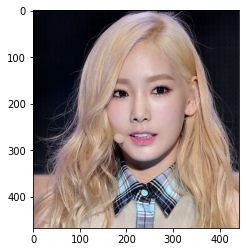

In [ ]:
#이미지 전처리 동작 확인하기

#1. 이미지 읽기

image_file_path = '/content/drive/MyDrive/imgdata/smr.jpg'
img = Image.open(image_file_path) #[높이][너비][RGB]

#2. 원본 이미지 표시
plt.imshow(img)
plt.show()

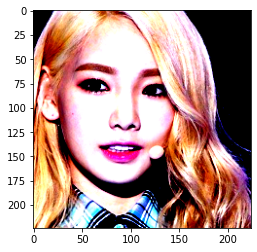

In [ ]:
#3. 이미지 전처리, 처리된 이미지 표시

size = 224

mean = (0.485, 0.456, 0.406)

std = (0.229, 0.224, 0.225)

transform = ImageTransform(size,mean,std)
img_transformed = transform(img,phase='train') #torch.Size([3,224,224])

#(색,높이,너비)를 (높이, 너비, 색상)으로 바꾸고 0-1로 값을 제한해 표시

img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed, 0,1)

#실행할때마다 결과가 다르다(random)
plt.imshow(img_transformed)
plt.show()

# 데이터 경로 리스트

In [ ]:
#이미지 파일의 경로 리스트 작성하기
def make_datapath_list(phase="train"):
    
    """
    데이터의 경로를 저장한 리스트를 작성한다.

    parameters
    -----------
    phase: 'train' or 'val'
        훈련 데이터 또는 검증 데이터를 지정
    
    Returns
    -----------
    path_list : list
        데이터 경로를 저장한 리스트
    """

    rootpath = "/content/drive/MyDrive/imgdata/personal_data/"
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)

    path_list = [] #여기에 저장

    #glob를 이용하여 하위 디렉토리의 파일 경로를 가져온다
    for path in glob.glob(target_path):
        
        path_list.append(path)
    
    return path_list

#실행
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

train_list

/content/drive/MyDrive/imgdata/personal_data/train/**/*.jpg
/content/drive/MyDrive/imgdata/personal_data/val/**/*.jpg


['/content/drive/MyDrive/imgdata/personal_data/train/summer/smr (39).jpg',
 '/content/drive/MyDrive/imgdata/personal_data/train/summer/smr (3).jpg',
 '/content/drive/MyDrive/imgdata/personal_data/train/summer/smr (14).jpg',
 '/content/drive/MyDrive/imgdata/personal_data/train/summer/smr (13).jpg',
 '/content/drive/MyDrive/imgdata/personal_data/train/summer/smr (37).jpg',
 '/content/drive/MyDrive/imgdata/personal_data/train/summer/smr (7).jpg',
 '/content/drive/MyDrive/imgdata/personal_data/train/summer/smr (8).jpg',
 '/content/drive/MyDrive/imgdata/personal_data/train/summer/smr (10).jpg',
 '/content/drive/MyDrive/imgdata/personal_data/train/summer/smr (5).jpg',
 '/content/drive/MyDrive/imgdata/personal_data/train/summer/smr.jpg',
 '/content/drive/MyDrive/imgdata/personal_data/train/summer/smr (18).jpg',
 '/content/drive/MyDrive/imgdata/personal_data/train/summer/smr (4).jpg',
 '/content/drive/MyDrive/imgdata/personal_data/train/summer/smr (34).jpg',
 '/content/drive/MyDrive/imgdata/pe

In [ ]:
val_list

['/content/drive/MyDrive/imgdata/personal_data/val/fall/8.jpg',
 '/content/drive/MyDrive/imgdata/personal_data/val/fall/10.jpg',
 '/content/drive/MyDrive/imgdata/personal_data/val/fall/1.jpg',
 '/content/drive/MyDrive/imgdata/personal_data/val/fall/5.jpg',
 '/content/drive/MyDrive/imgdata/personal_data/val/fall/4.jpg',
 '/content/drive/MyDrive/imgdata/personal_data/val/fall/3.jpg',
 '/content/drive/MyDrive/imgdata/personal_data/val/fall/6.jpg',
 '/content/drive/MyDrive/imgdata/personal_data/val/fall/2.jpg',
 '/content/drive/MyDrive/imgdata/personal_data/val/fall/9.jpg',
 '/content/drive/MyDrive/imgdata/personal_data/val/fall/7.jpg',
 '/content/drive/MyDrive/imgdata/personal_data/val/spring/10.jpg',
 '/content/drive/MyDrive/imgdata/personal_data/val/spring/2.jpg',
 '/content/drive/MyDrive/imgdata/personal_data/val/spring/6.jpg',
 '/content/drive/MyDrive/imgdata/personal_data/val/spring/3.jpg',
 '/content/drive/MyDrive/imgdata/personal_data/val/spring/1.jpg',
 '/content/drive/MyDrive/img

# dataset

In [ ]:
#이미지에 대한 dataset 작성

class PersonalDataset(data.Dataset):
    
    """
    이미지의 dataset class
    PyTorch의 dataset 클래스를 상속

    attributes
    -----------
    file_list : 리스트
        화상 경로를 저장한 리스트
    transform : object
        전처리 클래스의 인스턴스
    phase : 'train' or 'test'
        학습인지 훈련인지를 설정
    """

    def __init__(self, file_list, transform=None, phase='train'):
        
        self.file_list = file_list #파일 경로 리스트
        self.transform = transform #전처리 클래스의 인스턴스
        self.phase = phase #train or val 지정

    def __len__(self):
        
        """이미지 개수를 반환"""
        return len(self.file_list)
    
    def __getitem__(self,index):
        
        """
        전처리한 이미지의 tensor 형식의 데이터와 라벨 취득
        """

        #index번째의 이미지를 로드
        img_path = self.file_list[index]
        img = Image.open(img_path) #[높이][너비][색]

        #이미지 전처리
        img_transformed = self.transform(
            img, self.phase) #torch.Size([3,224,224])
            
        #이미지 라벨을 파일 이름에서 추출
        label = img_path.split('/')[7]
        
        #라벨을 숫자로 변경
        if label == 'spring':
            
            label = 0
        
        elif label == 'summer':
            
            label = 1
        
        elif label == 'fall':
            
            label = 2
        
        elif label == 'winter':
            
            label = 3
        
        return img_transformed, label

In [ ]:
#실행
train_dataset = PersonalDataset(
    file_list = train_list, transform = ImageTransform(size,mean,std), phase='train'
)

val_dataset = PersonalDataset(
    file_list = val_list, transform = ImageTransform(size,mean,std), phase='val'
)

#동작 확인

index = 0
print(train_dataset.__getitem__(index)[0].size()) #이미지 텐서 크기
print(train_dataset.__getitem__(index)[1]) #라벨

torch.Size([3, 224, 224])
1


# dataloader

In [ ]:
#미니 배치 크기
batch_size = 16

#dataloader 작성
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size = batch_size, shuffle=False
)

#쉽게 다루기 위해 사전형 변수에 정리
dataloaders_dict = {"train":train_dataloader, "val": val_dataloader}

#동작 확인
#반복자(iterator)로 변환
batch_iterator = iter(dataloaders_dict["train"])
inputs, labels = next(
    batch_iterator) #첫번째 요소를 추출
print(inputs.size())
print(labels)

torch.Size([16, 3, 224, 224])
tensor([3, 1, 3, 0, 1, 1, 3, 0, 3, 3, 0, 1, 2, 2, 0, 3])


# model load

In [ ]:
#학습된 mobilenetv2 모델을 로드
#모델의 인스턴스를 생성

use_pretrained = True #학습된 파라미터를 사용한다
net = models.mobilenet_v2(pretrained = use_pretrained)

#마지막 출력층의 출력 유닛을 spring,summer,fall,winter 4가지로 바꾼다

net.classifier[1] = nn.Linear(in_features=1280, out_features=4, bias=True)

# 훈련 모드
net.train()

print("네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했다.")

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했다.


# 손실함수 정의

In [ ]:
#손실 함수 설정
criterion = nn.CrossEntropyLoss()

# 최적화 기법 설정

In [ ]:
#전이학습에서 학습시킬 파라미터를 params_to_update 변수에 저장
params_to_update = []

#학습시킬 파라미터 이름
update_param_names = ["classifier.1.weight", "classifier.1.bias"]

#학습시킬 파라미터 이외에는 gradient를 계산하지 않고, 변하지 않게 설정
for name, param in net.named_parameters():
    if name in update_param_names:
        
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    
    else:
        
        param.requires_grad = False

#params_to_update의 내용을 확인
print("---------------")
print(params_to_update)

classifier.1.weight
classifier.1.bias
---------------
[Parameter containing:
tensor([[ 0.0044,  0.0158, -0.0210,  ...,  0.0113, -0.0147,  0.0064],
        [ 0.0056,  0.0191, -0.0009,  ...,  0.0083,  0.0205,  0.0021],
        [-0.0036, -0.0273,  0.0040,  ...,  0.0255,  0.0261, -0.0052],
        [ 0.0161, -0.0115,  0.0072,  ...,  0.0254,  0.0190,  0.0226]],
       requires_grad=True), Parameter containing:
tensor([ 0.0098,  0.0226, -0.0103, -0.0150], requires_grad=True)]


In [ ]:
#최적화 기법 설정
optimizer = optim.SGD(params = params_to_update, lr = 0.001, momentum = 0.9)

# 학습 및 검증

In [ ]:
#모델을 학습시키는 함수 작성

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    #epoch 루프
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('------------')

        #epoch별 학습 및 검증 루프
        for phase in ['train','val']:
            
            if phase == 'train':
                
                net.train() #모델을 훈련모드로
            
            else:
                
                net.eval() #모델을 검증 모드로

        
            epoch_loss = 0.0 #epoch 손실의 합
            epoch_corrects = 0 #epoch 정답의 수

            #미 학습시 검증 성능을 확인하기 위해 epoch=0의 훈련 생략
            if (epoch == 0) and (phase == 'train'):
                
                continue
            
            #데이터 로더로 미니 배치를 꺼내는 루프
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                
                #optimizer를 초기화
                optimizer.zero_grad()

                #forward path
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) #손실
                    _, preds = torch.max(outputs, 1) #라벨

                    #훈련시에는 역전파
                    if phase == 'train':
                        
                        loss.backward()
                        optimizer.step()
                    
                    #반복 결과 계산
                    #loss 합계 갱신

                    epoch_loss += loss.item() * inputs.size(0)

                    #정답 수의 합계 갱신
                    epoch_corrects += torch.sum(preds == labels.data)
            
            #epoch당 loss와 정답률 표시

            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)

            epoch_acc = epoch_corrects.double()/len(dataloaders_dict[phase].dataset)

            print('{}: Loss:{:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

In [ ]:
#학습, 검증 실시
num_epochs = 12
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/12
------------


100%|██████████| 2/2 [00:18<00:00,  9.31s/it]


val: Loss:1.4651 Acc: 0.1250
Epoch 2/12
------------


100%|██████████| 8/8 [01:03<00:00,  7.96s/it]


train: Loss:1.4174 Acc: 0.2213


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val: Loss:1.4627 Acc: 0.2188
Epoch 3/12
------------


100%|██████████| 8/8 [00:11<00:00,  1.46s/it]


train: Loss:1.3450 Acc: 0.3525


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


val: Loss:1.3758 Acc: 0.3750
Epoch 4/12
------------


100%|██████████| 8/8 [00:11<00:00,  1.50s/it]


train: Loss:1.3063 Acc: 0.3525


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val: Loss:1.3370 Acc: 0.2188
Epoch 5/12
------------


100%|██████████| 8/8 [00:12<00:00,  1.51s/it]


train: Loss:1.1847 Acc: 0.5000


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


val: Loss:1.2826 Acc: 0.3125
Epoch 6/12
------------


100%|██████████| 8/8 [00:12<00:00,  1.51s/it]


train: Loss:1.1048 Acc: 0.5656


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val: Loss:1.2648 Acc: 0.3750
Epoch 7/12
------------


100%|██████████| 8/8 [00:12<00:00,  1.53s/it]


train: Loss:1.0648 Acc: 0.6066


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


val: Loss:1.2220 Acc: 0.4062
Epoch 8/12
------------


100%|██████████| 8/8 [00:12<00:00,  1.54s/it]


train: Loss:0.9978 Acc: 0.6393


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


val: Loss:1.1874 Acc: 0.4375
Epoch 9/12
------------


100%|██████████| 8/8 [00:12<00:00,  1.50s/it]


train: Loss:0.9876 Acc: 0.6066


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


val: Loss:1.1920 Acc: 0.4375
Epoch 10/12
------------


100%|██████████| 8/8 [00:11<00:00,  1.46s/it]


train: Loss:0.9405 Acc: 0.6557


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val: Loss:1.1700 Acc: 0.4375
Epoch 11/12
------------


100%|██████████| 8/8 [00:11<00:00,  1.45s/it]


train: Loss:0.9038 Acc: 0.6639


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val: Loss:1.1311 Acc: 0.5000
Epoch 12/12
------------


100%|██████████| 8/8 [00:11<00:00,  1.48s/it]


train: Loss:0.8677 Acc: 0.7049


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]

val: Loss:1.2526 Acc: 0.4062


# 추론

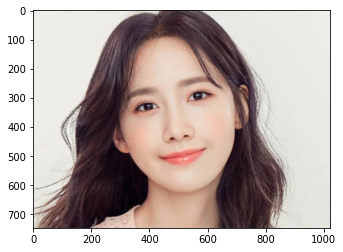

tensor([0])


In [ ]:
#1. 이미지 읽기

image_file_path = '/content/drive/MyDrive/imgdata/spring.jpg'
img = Image.open(image_file_path) #[높이][너비][RGB]

#2. 원본 이미지 표시
plt.imshow(img)
plt.show()

#3. 이미지 전처리

size = 224

mean = (0.485, 0.456, 0.406)

std = (0.229, 0.224, 0.225)

transform = ImageTransform(size,mean,std)
img_transformed = transform(img,phase='train') #torch.Size([3,224,224])

img_transformed = img_transformed.unsqueeze(0)

#inference
outputs = net(img_transformed)
_, preds = torch.max(outputs, 1) #라벨

print(preds) #봄